In [1]:
import os, pickle, re, collections
import pandas as pd
import numpy as np
# 
import matplotlib.pyplot as plt
from IPython.display import display
# 
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 
import xgboost as xgb
from xgboost import plot_importance

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

In [2]:
version = "v05"

# Load combined features with label

In [3]:
pdf_features_label = pd.read_pickle(os.path.join("features", "pdf_features_label.pkl.bz2"), compression="bz2")
meta_cols = ["SK_ID_CURR", "TARGET", "tvt_code"]
ls_features = [cname for cname in pdf_features_label.columns if cname not in meta_cols]

# 
print("Number of features: {}".format(len(ls_features)))
print(pdf_features_label.shape)
display(pdf_features_label.head().T)

Number of features: 353
(356255, 356)


,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
tvt_code,train,train,train,train,train
is_FLAG_EMP_PHONE,1,1,1,1,1
is_FLAG_WORK_PHONE,0,0,1,0,0
is_FLAG_PHONE,1,1,1,0,0
is_FLAG_EMAIL,0,0,0,0,0
is_REG_REGION_NOT_LIVE_REGION,0,0,0,0,0
is_REG_REGION_NOT_WORK_REGION,0,0,0,0,0
is_LIVE_REGION_NOT_WORK_REGION,0,0,0,0,0


In [4]:
pdf_features_label["tvt_code"].value_counts()

train          216948
kaggle_test    48744 
test           46127 
val            44436 
Name: tvt_code, dtype: int64

# Modeling (advanced)

In [5]:
def get_Xy_from_pdf(pdf_input, ls_features, tvt_code):
    pdf_data = pdf_input[pdf_input["tvt_code"] == tvt_code].copy()
    
    #
    X = pdf_data[ls_features]
    y = pdf_data["TARGET"]
    
    return X, y

def feature_selection_steps(
    pdf_input, 
    ls_features, 
    target_name,
    target_posval,
    idx_train,
    idx_test_list, 
    xgb_param_init, 
    xgb_param_fit,   
    options={}
  ):
    
    #
    default_options = {
        "nturn": 1,
        "random_state_ori": 1,
        "auc_check_per_turn_n": 1,
        "auc_delta_check_per_turn": -1,
        "ndrop_per_turn": 1
    }
    
    default_options.update(options)
    options = default_options

    # tracked vars  
    ls_fit_info = []
    auc_last_turn = 1.0
    ls_curr_features = ls_features

    ### start selecting features
    for turn in range(options["nturn"]):
        
        # store results in each turn check
        ls_xgb_model = [None] * options["auc_check_per_turn_n"]
        ls_tracked_auc = [None] * options["auc_check_per_turn_n"]
        ls_tracked_imp = [None] * options["auc_check_per_turn_n"]

        for j_turn in range(options["auc_check_per_turn_n"]):
            # init model
            xgb_param_init["random_state"] = options["random_state_ori"] + j_turn
            xgb_model=xgb.XGBClassifier(**xgb_param_init)

            # add eval set
            xgb_param_fit["eval_set"] = []
            for i_idx in [idx_train] + idx_test_list:
                X_i = pdf_input.loc[i_idx, ls_curr_features]
                y_i = (pdf_input.loc[i_idx, target_name] == target_posval).astype("i4")
                xgb_param_fit["eval_set"].append((X_i, y_i))

            # model fitting
            xgb_model.fit(X=pdf_input.loc[idx_train, ls_curr_features], 
                          y=(pdf_input.loc[idx_train, target_name] == target_posval).astype("i4"), 
                          **xgb_param_fit)
            #
            best_iteration = xgb_model.get_booster().best_iteration
            xgb_evals_result = xgb_model.evals_result()

            # get best auc list and sorted importance features
            ls_sub_auc = [xgb_evals_result[val_name]["auc"][best_iteration] for val_name in xgb_evals_result]
            ls_imp_feat = sorted(xgb_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: -x[1])

            # store result
            ls_xgb_model[j_turn] = xgb_model
            ls_tracked_auc[j_turn] = ls_sub_auc
            ls_tracked_imp[j_turn] = ls_imp_feat

            #
            print("Turn {} | j_repeat: {} | auc: {} | len(features): {} | len(importance): {}\n\n".format(turn, j_turn, ls_sub_auc, len(ls_curr_features), len(ls_imp_feat)))

            # early stop on last validation set
            if ls_sub_auc[-1] >= (auc_last_turn - options["auc_delta_check_per_turn"]):
                break

        # get max turn result on last validation set
        j_turn_max = max(range(j_turn + 1), key = lambda j_val: ls_tracked_auc[j_val][-1])
        selected_xgb_model = ls_xgb_model[j_turn_max]
        selected_auc_list = ls_tracked_auc[j_turn_max]
        selected_imp = ls_tracked_imp[j_turn_max]
        auc_last_turn = selected_auc_list[-1]

        # update info
        info = collections.OrderedDict([
                  ("auc", selected_auc_list), ("ls_tracked_auc", ls_tracked_auc), 
                  ("ls_curr_features", ls_curr_features), 
                  ("imp", selected_imp), ("ls_tracked_imp", ls_tracked_imp), 
                  ("model", selected_xgb_model)])
        ls_fit_info.append(info)
        print("Turn {} | j_max: {} | auc: {} | len(features): {} | len(importance): {}\n\n".format(turn, j_turn_max, selected_auc_list, len(ls_curr_features), len(selected_imp)))

        # update features list
        ls_curr_features = list(list(zip(*(selected_imp[:-options["ndrop_per_turn"]])))[0])

    return ls_fit_info

In [6]:
%%time
# get train/val/test index list
idx_train = pdf_features_label["tvt_code"] == "train"
idx_test_list = [pdf_features_label["tvt_code"] == "val", pdf_features_label["tvt_code"] == "test"]

#
param_init = {
    "objective": "binary:logistic", 
    "booster": "gbtree", 
    "max_depth": 4, # default: 3 only for depthwise
    "n_estimators": 1000, # default: 500  
    "learning_rate": 0.025, # default: 0.05 
    "subsample": 0.7, 
    "colsample_bytree": 0.6,  # default:  1.0
    "colsample_bylevel": 0.5, # default: 1.0
    "random_state": 0,
    
    #
    "silent": True, 
    "n_jobs": 16, 
    
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default depthwise
}

param_fit = {
    "eval_metric": "auc", 
    "early_stopping_rounds": 500, # default: 100
    "verbose": 200,
}

options = {
    # turn to filter features
    "nturn": 5,
    
    # turn to run random state
    "auc_check_per_turn_n": 5,
}

ls_res_selection_info = feature_selection_steps(
    pdf_input=pdf_features_label, 
    ls_features=ls_features, 
    target_name="TARGET",
    target_posval=0,
    idx_train=idx_train,
    idx_test_list=idx_test_list, 
    xgb_param_init=param_init, 
    xgb_param_fit=param_fit,
    options=options,
)

[0]	validation_0-auc:0.643981	validation_1-auc:0.633484	validation_2-auc:0.638298
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.757673	validation_1-auc:0.743233	validation_2-auc:0.754966
[400]	validation_0-auc:0.776767	validation_1-auc:0.755446	validation_2-auc:0.765157
[600]	validation_0-auc:0.787577	validation_1-auc:0.75946	validation_2-auc:0.769138
[800]	validation_0-auc:0.796434	validation_1-auc:0.761221	validation_2-auc:0.77117
[999]	validation_0-auc:0.804163	validation_1-auc:0.7621	validation_2-auc:0.772239
Turn 0 | j_repeat: 0 | auc: [0.804147, 0.762101, 0.77224] | len(features): 353 | len(importance): 291


[0]	validation_0-auc:0.675357	validation_1-auc:0.662808	validation_2-auc:0.678871
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.


[600]	validation_0-auc:0.787795	validation_1-auc:0.759141	validation_2-auc:0.769173
[800]	validation_0-auc:0.796538	validation_1-auc:0.760578	validation_2-auc:0.770849
[999]	validation_0-auc:0.804346	validation_1-auc:0.761739	validation_2-auc:0.7722
Turn 2 | j_repeat: 0 | auc: [0.804346, 0.761739, 0.7722] | len(features): 264 | len(importance): 260


[0]	validation_0-auc:0.679339	validation_1-auc:0.675943	validation_2-auc:0.679814
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.757971	validation_1-auc:0.743625	validation_2-auc:0.755675
[400]	validation_0-auc:0.776987	validation_1-auc:0.75565	validation_2-auc:0.765855
[600]	validation_0-auc:0.787723	validation_1-auc:0.759263	validation_2-auc:0.769702
[800]	validation_0-auc:0.796599	validation_1-auc:0.761117	validation_2-auc:0.771663
[999]	validation_0-auc:0.804382	validation_1-auc:0.762067	validation_2-a

Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.757657	validation_1-auc:0.743272	validation_2-auc:0.755571
[400]	validation_0-auc:0.777013	validation_1-auc:0.755584	validation_2-auc:0.765844
[600]	validation_0-auc:0.787748	validation_1-auc:0.759013	validation_2-auc:0.76901
[800]	validation_0-auc:0.796765	validation_1-auc:0.760935	validation_2-auc:0.770976
[999]	validation_0-auc:0.804448	validation_1-auc:0.761491	validation_2-auc:0.771876
Turn 4 | j_repeat: 1 | auc: [0.804264, 0.761495, 0.771876] | len(features): 251 | len(importance): 246


[0]	validation_0-auc:0.673672	validation_1-auc:0.665191	validation_2-auc:0.6808
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.758078	validation_1-auc:0.743609	validation_2-auc:0.755

In [7]:
i_max_turn = max(range(options["nturn"]), key=lambda i_res: ls_res_selection_info[i_res]["auc"][-1])
xgb_model_i = ls_res_selection_info[i_max_turn]["model"]
ls_auc_i = ls_res_selection_info[i_max_turn]["auc"]
ls_imp_i = ls_res_selection_info[i_max_turn]["imp"]
print("AUC: {}".format(ls_auc_i))

AUC: [0.80403, 0.763043, 0.773103]


In [8]:
# save model to file
res_model = ls_res_selection_info[i_max_turn]
res_model["features"] = ls_features
pickle.dump(res_model, open("models/xgb_model_{}.mod".format(version), "wb"))

# Model evaluates

In [9]:
# read model
with open("models/xgb_model_{}.mod".format(version), "rb") as input_file:
    res_model = pickle.load(input_file)
res_model.keys()

['auc',
 'ls_tracked_auc',
 'ls_curr_features',
 'imp',
 'ls_tracked_imp',
 'model',
 'features']

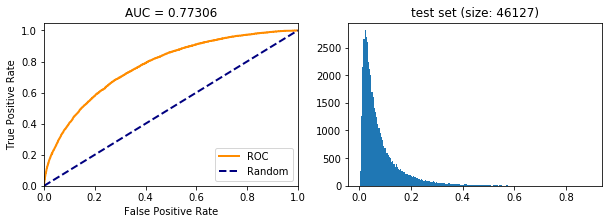

In [10]:
def visualize_auc(pdf, tvt_code, res_model, target_pred_posval=0):
    # get Xy and predict
    X, y = get_Xy_from_pdf(pdf, res_model["features"], tvt_code)
    y_pred = res_model["model"].predict_proba(X)[:, target_pred_posval]
    
    # get values
    auc_value = metrics.roc_auc_score(y, y_pred)
    res01 = metrics.roc_curve(y, y_pred)

    # plot
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
    lw = 2
    ax1.plot(res01[0], res01[1], color="darkorange",lw=lw, label="ROC")
    ax1.plot([0, 1], [0, 1], color="navy", label="Random", lw=lw, linestyle="--")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("AUC = %0.5f"%(auc_value))
    ax1.legend(loc="lower right")

    # prediction probability histogram
    ax2.set_title("{} set (size: {})".format(tvt_code, y.shape[0]))
    ax2.hist(y_pred, bins=200)

    plt.show()

# 
visualize_auc(pdf_features_label, "test", res_model)

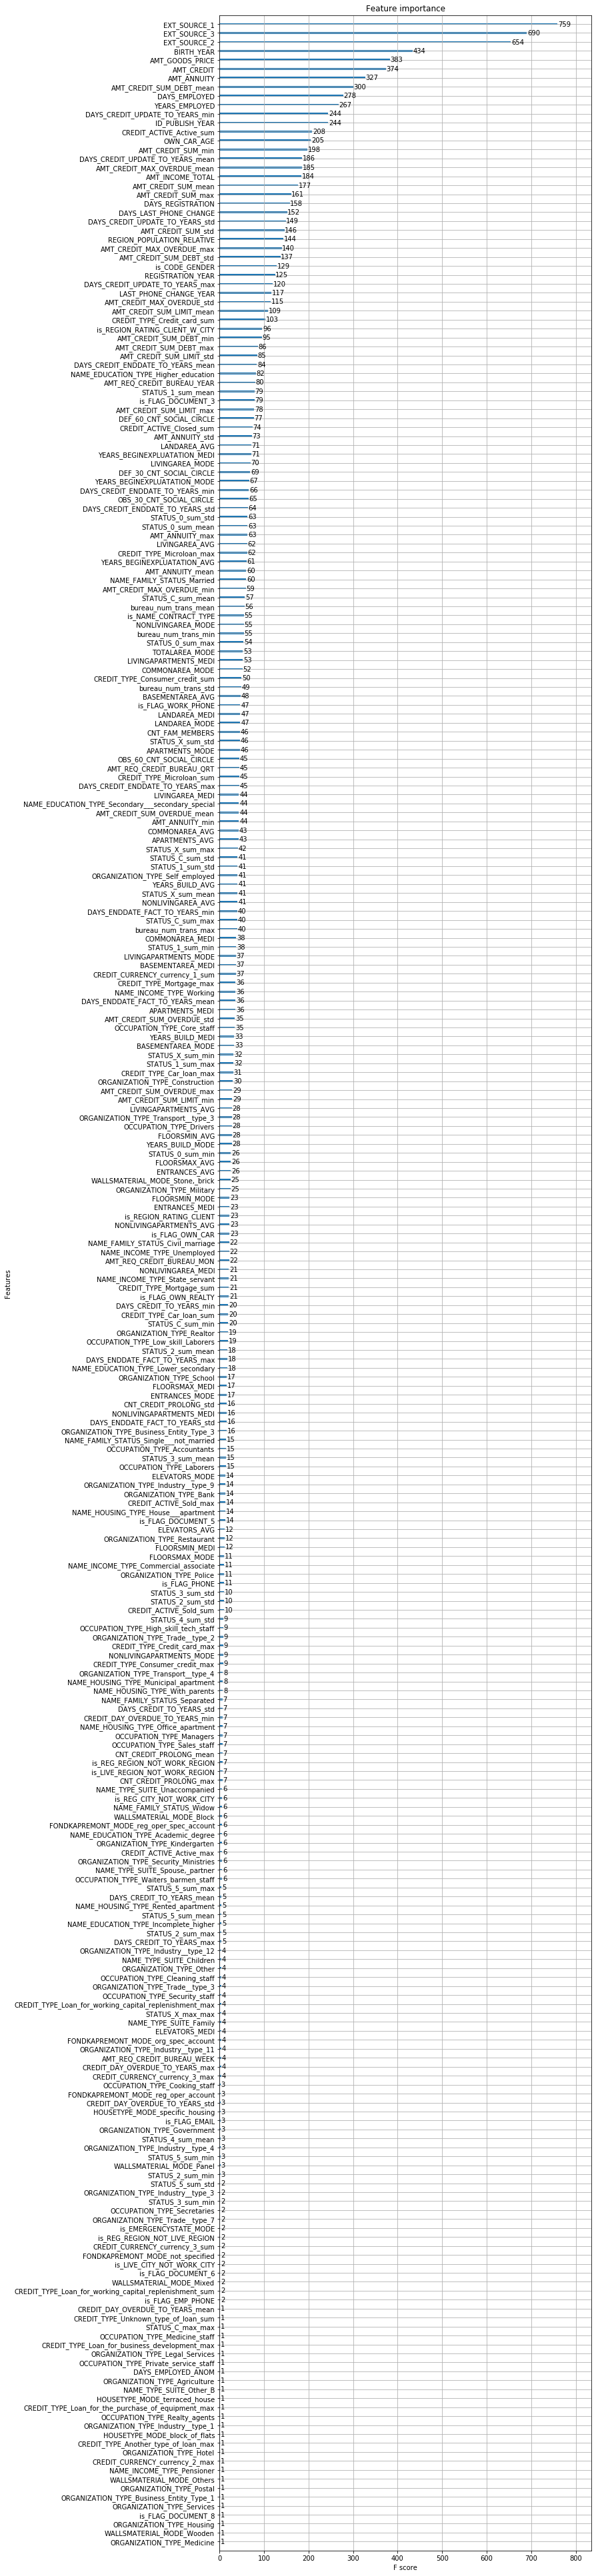

In [11]:
# 
fig_height = len(res_model["imp"]) / 4
fig, ax = plt.subplots(figsize=(10, fig_height))
plot_importance(res_model["model"], ax=ax)
plt.show()

In [12]:
pdf_imp = pd.DataFrame(res_model["imp"])
pdf_imp.rename(columns= {0: "feat_name", 1: "F-score"}, inplace=True) 
pdf_imp.head(50)

,feat_name,F-score
0,EXT_SOURCE_2,91.1670
1,EXT_SOURCE_3,89.1657
2,NAME_EDUCATION_TYPE_Higher_education,56.4533
3,NAME_INCOME_TYPE_Working,38.3542
4,is_FLAG_DOCUMENT_3,37.5288
5,is_CODE_GENDER,35.4549
6,NAME_EDUCATION_TYPE_Secondary___secondary_special,34.4263
7,EXT_SOURCE_1,32.6655
8,YEARS_EMPLOYED,29.3723
9,DAYS_CREDIT_TO_YEARS_mean,28.1202


# Save submission

In [13]:
target_pred_posval = 0
X_kaggle_test = pdf_features_label.query("tvt_code == 'kaggle_test'")[ls_features]
y_test_pred = res_model["model"].predict_proba(X_kaggle_test)[:, target_pred_posval]
y_test_pred.mean()

0.07816477

In [14]:
SK_IDs = pdf_features_label.query("tvt_code == 'kaggle_test'")["SK_ID_CURR"].tolist()
pdf_submiss = pd.DataFrame({"SK_ID_CURR": SK_IDs, "TARGET": y_test_pred})
pdf_submiss.to_csv("submissions/submission_{}.csv".format(version), index=False)
pdf_submiss.head()

,SK_ID_CURR,TARGET
0,100001,0.0415
1,100005,0.1651
2,100013,0.0250
3,100028,0.0345
4,100038,0.1615


![submission_baseline_v02](submissions/submission_baseline_v02.png "submission_baseline_v02")
![submission_baseline_v01](submissions/submission_baseline_v01.png "submission_baseline_v01")